In [1]:
import random
import numpy as np
import math
import quimb.tensor as qtn
import smpo
#import embeddings as fm

3
3


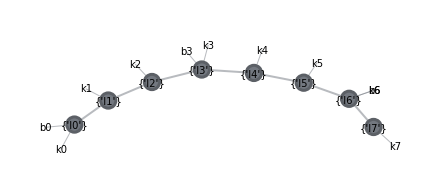

In [2]:
mpo = smpo.SpacedMatrixProductOperator.rand(n=8, spacing=3)

In [3]:
# mpo.draw()